# Solution proposed

## Pipeline consists of 2 steps. For each map:

### 1. Use a convolutional neural network to propose likely regions where the map is located.

### 2. Use template matching on the set of proposed regions to compute the exact coordinates.

### Download data for training

In [1]:
# # Only to run when using COLAB
# !mkdir data
# !mkdir data/train

# # Download train files
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fuaPrB210tMS3bYhAr9I2JIsXyjcuYgC' -O data/train.csv
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oIXTEvLlr7WSe28c9E_HWuowZE5bnq7q' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1oIXTEvLlr7WSe28c9E_HWuowZE5bnq7q" -O trainImages.zip && rm -rf /tmp/cookies.txt

# # Leaked test files, that I decided to use for training the model
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1skDLd9kLGz0LX4gOSSusaTj3pdYx-Ja2' -O data/trainNew.csv
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=15MDsiiuMOy8i6dbGbQJ0cCWr5SG9LFQR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=15MDsiiuMOy8i6dbGbQJ0cCWr5SG9LFQR" -O trainImagesNew.zip && rm -rf /tmp/cookies.txt
# !ls -ltr .

# # unzip train images into its folders
# !unzip -o trainImages.zip -d ./data/train/
# !unzip -o trainImagesNew.zip -d ./data/train/
# !ls  ./data/train/*.png | wc -l
# !ls -ltr .

In [2]:
import json
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import numpy as np
import pandas as pd
import math
import random
import cv2
import glob
from datetime import datetime
from tqdm import tqdm
import pickle
from multiprocessing import Pool, cpu_count

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
if tf.__version__ < '2.1.0':
    raise Exception('Please use TF version >= 2.1.0')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

# -------------
# own modules
# -------------
from util import *

# custom object that acts as a convenient wrapper
# around a map
# from map_image import MapImage

# iterator to read images from disk, preprocess them and feed them
# to the CNN during training and testing time
# from data_generator import DataGenerator

# from model_factory import create_vgg_based_model

# custom object that acts as a wrapper. It essentially contains
# a dictionary that maps each cluster to a list of representative maps
# from the train set
from cluster_representative_maps import ClusterRepresentativeMaps

2.1.0


## Wrapper objects and util functions (ideally they should be in separate .py files but due to restrictions in the submission format I pasted them here)

In [152]:
def id2path(images_dir, image_id):
    """Auxiliar function that maps images ids to images full paths"""
    image_file = image_id + '.png'
    return os.path.join(images_dir, image_file)

def path2id(path):
    return os.path.basename(path).split('.')[0]

def id2file(image_id):
    return image_id + '.png'

### Wrapper object

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

class MapImage:

    def __init__(self, coordinates=None, image_id=None, image_path=None,
                 image_type=None, image_dim=None):

        self.coordinates = coordinates
        self.image_id = image_id
        self.image_path = image_path

        if (not image_path) and (not image_dim):
            raise Exception('Provide either an image_path or '
                            'image_dimensions (width, height) in pixels')

        self.image = None
        self.image_type = None

        self.has_been_preprocessed = False
        self.has_been_normalized = False

        if self.image_path:
            # load image if path was provided
            self.image = self._load_image()
            if image_type:
                self.image_type = image_type
            else:
                self.image_type = self._get_image_type()
        else:
            # create a black image with given dimensions
            self.image = np.zeros((image_dim[0], image_dim[1], 3),
                                  dtype=np.uint8)

        # keep track of how noisy the original image was
        # self.percentage_noisy_pixels = None

    def print_info(self):

        output_strings = [
            f'[res: {int(self.px_per_lon_ratio)} x {int(self.px_per_lat_ratio)}]',
            f'[size: {self.width_px} x {self.height_px}]',
            f'[type: {self.image_type}]',
            f'[center: {self.central_point}]',
        ]
        output_str = ''.join(output_strings)
        print(output_str)

    def _load_image(self):
        """
        Returns RGB image
        """
        image = cv2.imread(self.image_path, 3)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def preprocess_image_old(self):

        # to gray-scale
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

        # blur (supposed to delete straight lines)
        self.image = cv2.medianBlur(self.image, ksize=35)
        ret, self.image = cv2.threshold(self.image, thresh=185, maxval=255,
                                        type=cv2.THRESH_BINARY)
        self.image = np.repeat(self.image[:, :, np.newaxis], 3, axis=2)

    def preprocess_image_new(self):

        if not self.has_been_preprocessed:
            if self.image_type == 'blue-green':
                self._detect_and_remove_noise()
                self._set_known_land_pixels_to_black()

            # to gray-scale
            self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

            # blur (supposed to delete straight lines)
            self.image = cv2.medianBlur(self.image, ksize=45)
            ret, self.image = cv2.threshold(self.image, thresh=185, maxval=255,
                                            type=cv2.THRESH_BINARY)
            self.image = np.repeat(self.image[:, :, np.newaxis], 3, axis=2)

            self.has_been_preprocessed = True

    def normalize_pixel_range(self):
        if not self.has_been_normalized:
            self.image = self.image / 255
            self.has_been_normalized = True

    def _set_known_land_pixels_to_black(self):

        land_colors_rgb = [
            {'color': [216, 208, 195], 'diff': 20},
            {'color': [199, 211, 209], 'diff': 15},
            {'color': [226, 232, 242], 'diff': 10},
            {'color': [169, 191, 199], 'diff': 10},
            {'color': [169, 201, 187], 'diff': 10},
            {'color': [189, 205, 186], 'diff': 10},
            # {'color': [182, 190, 209], 'diff': 10},
        ]
        for x in land_colors_rgb:
            diff = x['diff']
            color = x['color']
            lower = np.array([(color[i] - diff) for i in range(0, 3)],
                             dtype=np.uint8)
            upper = np.array([(color[i] + diff) for i in range(0, 3)],
                             dtype=np.uint8)
            mask = cv2.inRange(self.image, lower, upper)
            self.image[mask == 255] = [0, 0, 0]

    def _detect_and_remove_noise(self):

        # detect artificial straight lines and replace them with white
        hsv_img = cv2.cvtColor(self.image, cv2.COLOR_RGB2HSV)

        # saturation above 70 seems to work well
        low_H = 0
        high_H = 180
        low_S = 80  # 110?
        high_S = 255
        low_V = 0
        high_V = 255

        mask = cv2.inRange(hsv_img, (low_H, low_S, low_V),
                           (high_H, high_S, high_V))

        # replace noisy lines with white color
        # TODO: maybe improve this?
        self.image[mask == 255] = [255, 255, 255]
        # self.plot()

    def _get_image_type(self):
        """
        Image type in {'white-orange', 'white-gray', 'blue-green'}
        """
        # get percentage of white pixels in image
        ratio_white_pixels = \
            self._get_percentage_pixels_given_color([255, 255, 255])

        # get percentage of orange pixels in image
        ratio_gray_pixels = \
            self._get_percentage_pixels_given_color([128, 128, 128])

        ratio_orange_pixels = \
            self._get_percentage_pixels_given_color([244, 164, 96])

        if (ratio_white_pixels > 0.20) and (ratio_gray_pixels > 0.05):
            image_type = 'white-gray'
        #         elif ratio_white_pixels > 0.20:
        #             image_type = 'white-orange'
        elif ratio_orange_pixels > 0.03:
            image_type = 'white-orange'
        elif ratio_gray_pixels > 0.05:
            image_type = 'white-gray'
        elif ratio_white_pixels > 0.50:
            image_type = 'white-gray'
        else:
            image_type = 'blue-green'

        return image_type

    def _get_percentage_pixels_given_color(self, color_rgb):
        """
        Given 'color_rgb' this function returns the percentage of image pixels
        of this color.
        """
        diff = 0
        boundaries = [
            ([color_rgb[0] - diff, color_rgb[1] - diff, color_rgb[2] - diff],
             [color_rgb[0] + diff, color_rgb[1] + diff, color_rgb[2] + diff])]

        for (lower, upper) in boundaries:
            lower = np.array(lower, dtype=np.uint8)
            upper = np.array(upper, dtype=np.uint8)
            mask = cv2.inRange(self.image, lower, upper)
            ratio_color = cv2.countNonZero(mask) / (self.image.size / 3)

        return ratio_color

    @property
    def central_point(self):
        if self.coordinates:
            center = [0.5 * (self.ll_lon + self.ur_lon),
                      0.5 * (self.ll_lat + self.ur_lat)]

            # beautify coordinates
            e_w = 'E'
            lon = center[0]
            if center[0] < 0:
                e_w = 'W'
                lon = -center[0]
            n_s = 'N'
            lat = center[1]
            if center[1] < 0:
                n_s = 'S'
                lat = -center[1]

            lon = round(lon, 1)
            lat = round(lat, 1)

            return f'{lat}°{n_s} {lon}°{e_w}'
        else:
            raise Exception('Map coordinates not specified')

    @property
    def ll_lon(self):
        if self.coordinates:
            return self.coordinates[0]
        else:
            raise Exception('Map coordinates not specified')

    @property
    def ll_lat(self):
        if self.coordinates:
            return self.coordinates[1]
        else:
            raise Exception('Map coordinates not specified')

    @property
    def ur_lon(self):
        if self.coordinates:
            return self.coordinates[2]
        else:
            raise Exception('Map coordinates not specified')

    @property
    def ur_lat(self):
        if self.coordinates:
            return self.coordinates[3]
        else:
            raise Exception('Map coordinates not specified')

    @property
    def px_per_lon_ratio(self):
        if self.coordinates:
            if self.ll_lon > self.ur_lon:
                # edge case that happens in Australia
                return self.width_px / (360 - self.ll_lon + self.ur_lon)
            else:
                return self.width_px / (self.ur_lon - self.ll_lon)

        else:
            raise Exception('Map coordinates not specified')

    @property
    def px_per_lat_ratio(self):
        if self.coordinates:
            return self.height_px / (self.ur_lat - self.ll_lat)
        else:
            raise Exception('Map coordinates not specified')

    @property
    def area(self):
        return abs((self.ur_lon - self.ll_lon) * (self.ur_lat - self.ll_lat))

    def plot(self):
        plt.imshow(self.image)
        plt.show()

    @property
    def shape(self):
        return self.image.shape

    @property
    def width_px(self):
        return self.image.shape[1]

    @property
    def height_px(self):
        return self.image.shape[0]

    def resize_by_scaling_factor(self, scaling_factor):
        """
        """
        new_height = int(scaling_factor * self.height_px)
        new_width = int(scaling_factor * self.width_px)
        new_dim = (new_width, new_height)
        self.image = cv2.resize(self.image, new_dim,
                                interpolation=cv2.INTER_AREA)

    def plot_hsv_3d_scatterplot(self):

        img = self.image.copy()

        pixel_colors = img.reshape((np.shape(img)[0] * np.shape(img)[1], 3))
        norm = colors.Normalize(vmin=-1., vmax=1.)
        norm.autoscale(pixel_colors)
        pixel_colors = norm(pixel_colors).tolist()

        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_img)
        fig = plt.figure(figsize=(20, 10))
        axis = fig.add_subplot(1, 2, 1, projection="3d")
        axis.scatter(h.flatten(), v.flatten(), s.flatten(),
                     facecolors=pixel_colors,
                     marker=".")
        axis.set_xlabel("Hue")
        axis.set_ylabel("Value")
        axis.set_zlabel("Saturation")

        axis = fig.add_subplot(1, 2, 2, projection="3d")
        axis.scatter(s.flatten(), h.flatten(), v.flatten(),
                     facecolors=pixel_colors,
                     marker=".")
        axis.set_xlabel("Saturation")
        axis.set_ylabel("Hue")
        axis.set_zlabel("Value")

        plt.show()



### Iterator to feed data into the neural network

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import random

class DataGenerator(tf.keras.utils.Sequence):
    """
    Generator of data batches, to be fed into the model during
    training and testing.
    """

    def __init__(self, image_ids,
                 map_id_to_path,
                 map_id_to_class,
                 batch_size=32,
                 output_dim=(224, 224, 3),
                 n_classes=10,
                 shuffle=True,
                 train=True,
                 debug=False):
        self.image_ids = image_ids
        self.map_id_to_path = map_id_to_path
        self.map_id_to_class = map_id_to_class

        self.batch_size = batch_size
        self.output_dim = output_dim
        self.n_classes = n_classes

        self.shuffle = shuffle

        # TODO: floods memory
        # self.map_images = self._load_map_images()

        # flag to distinguish train from test mode
        self.train = train
        self.debug = debug

        self.indexes = None
        self.on_epoch_end()

    def _load_map_images(self):

        map_images = dict()
        for image_id in self.image_ids:
            map_image = MapImage(image_id=image_id,
                                 image_path=self.map_id_to_path[image_id])

            # TODO: enable them to make training faster
            #             map_image.preprocess_image_new()
            #             map_image.normalize_pixel_range()

            map_images[image_id] = map_image

        return map_images

    def _load_map_image(self, image_id):

        map_image = MapImage(image_id=image_id,
                             image_path=self.map_id_to_path[image_id])

        return map_image

    def __getitem__(self, index):
        """
        Returns one batch of data
        """
        # generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:
                               (index + 1) * self.batch_size]

        # Find list of image ids
        list_ids_temp = [self.image_ids[k] for k in indexes]

        # generate data
        if self.debug:
            X, y, original_images = self._data_generation(list_ids_temp)
        else:
            X, y = self._data_generation(list_ids_temp)

        if self.train:
            if self.debug:
                return X, y, original_images
            else:
                return X, y
        else:
            return X

    def _data_generation(self, image_ids_batch):
        """
        Generates data containing batch_size samples
        """
        X = np.empty((self.batch_size, self.output_dim[0],
                      self.output_dim[1], self.output_dim[2]))
        y = np.empty(self.batch_size, dtype=int)

        # used for debugging purposes
        original_images = list()

        for i, image_id in enumerate(image_ids_batch):

            map_image = self._load_map_image(image_id)

            if self.debug:
                # store
                original_images.append(np.copy(map_image.image))

            map_image.preprocess_image_new()
            map_image.normalize_pixel_range()
            # self.map_images[image_id].plot()

            image = map_image.image
            # image = self._get_square_crop(image, 224)
            image = self._get_random_square_crop(image, self.output_dim[0])
            # plt.imshow(image)
            # plt.show()

            # store image in numpy array
            X[i, :] = image
            if self.train:
                y[i] = self.map_id_to_class[image_id]

        if self.debug:
            return X, y, original_images
        else:
            return X, y

    @staticmethod
    def _get_square_crop(image, length):
        """
        Returns a centered squared crop of maximal dimensions
        """
        #         initial_square_length = min(image.shape[0], image.shape[1])

        width = image.shape[1]
        height = image.shape[0]

        if width > height:
            # width > height
            square_length = height
            x0 = 0
            x1 = square_length
            y0 = int((width / 2) - (square_length / 2))
            y1 = int((width / 2) + (square_length / 2))

        else:
            # height >=  width
            square_length = width
            x0 = int((height / 2) - (square_length / 2))
            x1 = int((height / 2) + (square_length / 2))
            y0 = 0
            y1 = square_length

        image = image[x0:x1, y0:y1, :]

        final_dim = (length, length)
        image = cv2.resize(image, final_dim)

        return image

    @staticmethod
    def _get_random_square_crop(image, length):
        """
        Returns a centered squared crop of maximal dimensions
        """
        width = image.shape[1]
        height = image.shape[0]

        noise = random.uniform(-0.95, 0.95)
        # noise_2 = random.uniform(0.90, 1) # do not allow too low values

        if width > height:
            # width > height
            square_length = height
            x0 = 0
            x1 = square_length

            d = (width - square_length) / 2
            y0 = int(d + (noise * d))
            y1 = int(y0 + square_length)
            # y0 = int((width / 2) - (square_length / 2))
            # y1 = int((width / 2) + (square_length / 2))

        else:
            # height >=  width
            square_length = width
            y0 = 0
            y1 = square_length

            d = (height - square_length) / 2
            x0 = int(d + (noise * d))
            x1 = int(x0 + square_length)
            # x0 = int((height / 2) - (square_length / 2))
            # x1 = int((height / 2) + (square_length / 2))

        image = image[x0:x1, y0:y1, :]

        final_dim = (length, length)
        image = cv2.resize(image, final_dim)

        return image

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [154]:
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_vgg_based_model(input_image_size, n_output_classes,
                           vgg_type=None, vgg_layers_to_train=None):
    """
    Creates and returns a NN based on VGG backbone.
    Model = Base Model (VGG) + Extra layers to train
    
    """
    if vgg_type not in ['VGG16', 'VGG19']:
        raise Exception('vgg_type has an invalid value')

    # backbone model
    if vgg_type == 'VGG16':
        base_model = VGG16(weights="imagenet", include_top=False,
                           input_tensor=Input(shape=(input_image_size,
                                                     input_image_size,
                                                     3)))
    else:
        base_model = VGG19(weights="imagenet", include_top=False,
                           input_tensor=Input(shape=(input_image_size,
                                                     input_image_size,
                                                     3)))

    # construct the head of the model that will be placed on top of the
    # the base model
    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(4, 4))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(64, activation="relu")(head_model)
    # head_model = Dropout(0.5)(head_model)
    head_model = Dense(n_output_classes, activation="softmax")(head_model)
    
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=base_model.input, outputs=head_model)

    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in base_model.layers:
        if layer.name in vgg_layers_to_train:
            layer.trainable = True
        else:
            layer.trainable = False
    
    return model

In [155]:
import random
import numpy as np
import math

class ClusterRepresentativeMaps:

    def __init__(self, n_map_clusters, n_maps_per_cluster, map_id_to_metadata,
                 map_class_to_image_ids, map_id_to_path,
                 map_id_to_actual_coordinates,
                 resize_factor=1):

        self.n_map_clusters = n_map_clusters
        self.n_maps_per_cluster = n_maps_per_cluster
        self.map_id_to_metadata = map_id_to_metadata
        self.map_class_to_image_ids = map_class_to_image_ids

        self.map_id_to_path = map_id_to_path
        self.map_id_to_actual_coordinates = map_id_to_actual_coordinates

        self.resize_factor = resize_factor

        self.map_class_to_map_ids = None
        self.map_class_to_map_images = None

        self.map_class_to_min_width_px = None
        self.map_class_to_min_height_px = None

    def generate_map_class_to_map_ids(self):
        """
        """
        self.map_class_to_map_ids = dict()

        for cluster in range(0, self.n_map_clusters):

            image_ids = \
                self._get_ids_maps_with_diverse_resolution_and_distance_to_center(
                    cluster)

            # add random ones if necessary until we have 'n_maps_per_cluster'
            n_missing_elements = self.n_maps_per_cluster - len(image_ids)
            if n_missing_elements > 0:
                other_ids = list(
                    set(self.map_class_to_image_ids[cluster]) - set(image_ids))
                other_ids = random.sample(other_ids, n_missing_elements)
                image_ids += other_ids

            self.map_class_to_map_ids[cluster] = image_ids
            print(f'Cluster {cluster}, {len(image_ids)} maps')

    def generate_map_class_to_map_images(self):
        """
        """
        if not self.map_class_to_map_ids:
            self.generate_map_class_to_map_ids()

        self.map_class_to_map_images = dict()
        self.map_class_to_min_width_px = dict()
        self.map_class_to_min_height_px = dict()

        for cluster in range(0, self.n_map_clusters):
            map_images = list()
            for image_id in self.map_class_to_map_ids[cluster]:
                map_image = MapImage(image_id=image_id,
                                     image_path=self.map_id_to_path[image_id],
                                     coordinates=
                                     self.map_id_to_actual_coordinates[
                                         image_id])
                map_image.preprocess_image_new()

                # e.g. to decrease resolution and speed up template matching
                map_image.resize_by_scaling_factor(self.resize_factor)

                map_images.append(map_image)

            # compute min width/height
            self.map_class_to_min_width_px[cluster] = \
                min([m.width_px for m in map_images])
            self.map_class_to_min_height_px[cluster] = \
                min([m.height_px for m in map_images])

            self.map_class_to_map_images[cluster] = map_images
            print(f'Cluster {cluster}, {len(map_images)} maps')

    def get_min_width_px(self, cluster):
        return self.map_class_to_min_width_px[cluster]

    def get_min_height_px(self, cluster):
        return self.map_class_to_min_height_px[cluster]

    def get_map_representatives(self, cluster):
        return self.map_class_to_map_images[cluster]

    def _get_ids_maps_with_diverse_resolution_and_distance_to_center(self,
                                                                     cluster):
        """
        Finds representative maps for each cluster. It does so, by trying to
        cover the whole resolution space and different distances to the cluster
        center.

        TODO: new version that partitions space of maps inside a cluster according
        to the following 3 dimenstions:
        - distance_to_center (polar coordinate 1)
        - degrees_from_center (polar coordinate 2)
        - resolution
        """
        # list of image_ids for this cluster, for which we have
        # metadata
        image_ids = self.map_class_to_image_ids[cluster]
        ids_with_metadata = [i for i in self.map_id_to_metadata.keys()]
        image_ids = list(set(image_ids) & set(ids_with_metadata))

        # compute range of resolution
        # enough to work with horizontal resolution (h and v are highly correlated)
        resolutions = [self.map_id_to_metadata[i]['px_per_lon_ratio'] for i in
                       image_ids]
        res_min = min(resolutions)
        res_max = max(resolutions)
        res_num_steps = int(math.sqrt(self.n_maps_per_cluster))
        res_step = (res_max - res_min) / res_num_steps
        # print('Resolution')
        # print(f'min: {res_min}, max: {res_max}, step: {res_step}')

        # compute range of distance to the cluster center
        distances = [self.map_id_to_metadata[i]['distance_to_center'] for i in
                     image_ids]
        d_min = min(distances)
        d_max = max(distances)
        d_num_steps = int(math.sqrt(self.n_maps_per_cluster))
        d_step = (d_max - d_min) / d_num_steps
        # print('Distance to center')
        # print(f'min: {d_min}, max: {d_max}, step: {d_step}')

        # parameter (no reason to change if from 1)
        max_maps_per_bucket = 1

        n_maps_per_bucket = np.zeros((res_num_steps, d_num_steps),
                                     dtype=np.uint32)
        # print(n_maps_per_bucket)

        selected_image_ids = list()
        for image_id in image_ids:
            # resolution
            res = self.map_id_to_metadata[image_id]['px_per_lon_ratio'] - 0.01
            d = self.map_id_to_metadata[image_id]['distance_to_center'] - 0.01

            r_bucket = int((res - res_min) / res_step)
            d_bucket = int((d - d_min) / d_step)
            # print('res: ', res, r_bucket)
            # print('d: ', d, d_bucket)
            n_maps_in_this_bucket = n_maps_per_bucket[r_bucket, d_bucket]

            if n_maps_in_this_bucket < max_maps_per_bucket:
                # pick this map
                selected_image_ids.append(image_id)

                # update counter
                n_maps_per_bucket[r_bucket, d_bucket] += 1
                # print(n_maps_per_bucket)

        return selected_image_ids

## Notebook parameters

In [66]:
N_MAP_CLUSTERS = 150

# Part 1: CNN training
# ------------------------
# Create train/test split or load it from csv file
IMAGES_DIR = 'data/train'
TEST_SPLIT = 0.20

# parameters for the CNN training
IMAGE_WIDTH = IMAGE_HEIGHT = 128
BATCH_SIZE = 32
N_CLASSES = N_MAP_CLUSTERS
BACKBONE_NN = 'VGG16'
BACKBONE_LAYERS_TO_TRAIN = ['block4_conv1', 'block5_conv1']
# training schedule
LEARNING_RATES = [3e-4, 3e-5, 3e-6]  # custom learning decay
EPOCHS = [1, 1, 1]
TOTAL_EPOCHS = sum(EPOCHS)

MODEL_NAME = f'{N_MAP_CLUSTERS}clusters_{BACKBONE_NN}_{TOTAL_EPOCHS}epochs'

# model checkpoints (only weights)
CHECKPOINT_DIR = f'saved_weights/{MODEL_NAME}/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

FINAL_MODEL_WEIGHTS = f'./saved_weights/{MODEL_NAME}_final/'

# Part 2: Template matching for coordinates calculation
# ------------------------
N_CLUSTER_CANDIDATES = 10
N_MAPS_PER_CLUSTER = 16
N_CROPS = 3
RESIZE_FACTOR_TEMPLATE_MATCHING = 0.25
THRESHOLD_PROB_FIRST_CLUSTER = 0.70

# 1. CNN training

### Load coordinates file

In [4]:
train = pd.read_csv('data/train.csv', index_col=0)
trainNew = pd.read_csv('data/trainNew.csv', index_col=0)

target = pd.concat([train, trainNew], axis=0)

print(target.head(10))
print(len(target))

           id   llcrnrlon  llcrnrlat   urcrnrlon  urcrnrlat
0  aa5b6e01eb   52.635221  21.939847   60.276093  28.262239
1  e5a3b9d07d  123.974550  -6.746330  129.139013  -0.813028
2  3d7cedf92f  106.033993  10.328013  112.494841  18.005732
3  6f2fdf0368   54.051684  22.264178   59.123211  26.997385
4  5addc798b4  -40.403236  62.752617  -26.507330  70.153543
5  ddb27f85c0  -78.989740 -54.391308  -67.924797 -47.881368
6  d7e09a4a31  -52.643921  58.749963  -42.687544  62.697276
7  5bd2f2d225   77.343019   8.265528   82.347628  14.510404
8  89a14f09d8  -62.540592  44.760961  -55.601705  50.819461
9  980fc0a257  154.860601  67.369130  170.047838  71.235238
40000


### Auxiliar mappings

In [5]:
# image_id --> target vector (4 dimensions)
map_id_to_target = dict()
for i, row in target.iterrows():
    image_id = row['id']
    ll_lon = row['llcrnrlon']
    ll_lat = row['llcrnrlat']
    ur_lon = row['urcrnrlon']
    ur_lat = row['urcrnrlat']
    map_id_to_target[image_id] = [ll_lon, ll_lat, ur_lon, ur_lat]

# image_id --> image_path
map_id_to_path = dict()
for id_ in target['id']:
    map_id_to_path[id_] = id2path(IMAGES_DIR, id_)

### Train/test split images ids

In [6]:
# create train/test split
image_ids = list(target['id'])

# generate train/test split and save it to disk
print(f'{len(image_ids)} images, {len(set(image_ids))} unique ids')
n_test_images = int(TEST_SPLIT * len(image_ids))

random.seed(30) # very important to fix the seed
test_images_ids = random.sample(image_ids, n_test_images)
train_images_ids = list(set(image_ids) - set(test_images_ids))

print(f'{len(train_images_ids)} train images')
print(f'{len(test_images_ids)} test images')

# list of images ids, train/test
ids = dict()
ids['train'] = train_images_ids
ids['test'] = test_images_ids

# save to csv files
train_ids_df = pd.DataFrame()
train_ids_df['id'] = ids['train']
train_ids_df.to_csv('train_ids.csv')   
test_ids_df = pd.DataFrame()
test_ids_df['id'] = ids['test']
test_ids_df.to_csv('test_ids.csv')

40000 images, 40000 unique ids
32000 train images
8000 test images


### Use K-means to generate clusters of maps. These are the classes the CNN will learn to predict
**Important**: Use only train data to generate cluster centers!
Otherwise there is a data leakage, which will artificially lower the test error when training the CNN.

In [7]:
data = target[['llcrnrlon', 'llcrnrlat', 'urcrnrlon', 'urcrnrlat']].to_numpy()

train_df = target.loc[target['id'].isin(ids['train'])]
train = train_df[['llcrnrlon', 'llcrnrlat', 'urcrnrlon', 'urcrnrlat']].to_numpy()

# use train data to determine cluster centers
kmeans = KMeans(n_clusters=N_MAP_CLUSTERS, random_state=12345)
kmeans = kmeans.fit(train)

# predict classes for all data, both train and test
target['class'] = kmeans.predict(data)

# add column with distance to cluster center
centers = np.empty((len(target), 4))
for i, label in enumerate(target['class']):
    center = kmeans.cluster_centers_[label]
    centers[i, :] = center

distances = np.sqrt(np.sum(np.square(data - centers), axis=1))
target['distance'] = distances
target

,id,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,class,distance
0,aa5b6e01eb,52.635221,21.939847,60.276093,28.262239,8,3.330392
1,e5a3b9d07d,123.974550,-6.746330,129.139013,-0.813028,28,4.499446
2,3d7cedf92f,106.033993,10.328013,112.494841,18.005732,87,5.853175
3,6f2fdf0368,54.051684,22.264178,59.123211,26.997385,8,2.658248
4,5addc798b4,-40.403236,62.752617,-26.507330,70.153543,24,1.452623
...,...,...,...,...,...,...,...
39995,1b46b2f659,7.445420,53.306584,15.020541,57.926219,26,1.554370
39996,d99c3e8365,8.271182,53.009906,15.479329,56.659583,26,2.362536
39997,7a06a12b53,122.410910,9.150275,128.581979,15.042010,25,4.646849
39998,6afb27f9c5,118.375456,-12.817320,125.647640,-4.235364,72,5.015928


### Auxiliary mappings

In [8]:
# image_id --> image_class (cluster)
map_id_to_actual_class = dict()
for i, row in target.iterrows():
    map_id_to_actual_class[row['id']] = row['class']
    
map_id_to_actual_coordinates = dict()
for _, row in target.iterrows(): 
    map_id_to_actual_coordinates[row['id']] = [row['llcrnrlon'],
                                               row['llcrnrlat'],
                                               row['urcrnrlon'],
                                               row['urcrnrlat']]
# image_id --> target vector (4 dimensions)
map_id_to_target = dict()
for i, row in target.iterrows():
    image_id = row['id']
    ll_lon = row['llcrnrlon']
    ll_lat = row['llcrnrlat']
    ur_lon = row['urcrnrlon']
    ur_lat = row['urcrnrlat']
    map_id_to_target[image_id] = [ll_lon, ll_lat, ur_lon, ur_lat]

### Data generators to feed images into the network

In [9]:
params = {
    'batch_size': BATCH_SIZE,
    'output_dim': [IMAGE_WIDTH, IMAGE_HEIGHT, 3],
    'n_classes': N_CLASSES,
    'shuffle': True,
    'debug': False
}

train_data_generator = DataGenerator(ids['train'], map_id_to_path, map_id_to_actual_class, **params)
test_data_generator = DataGenerator(ids['test'],  map_id_to_path, map_id_to_actual_class, **params)

### Create model architecture

In [10]:
model = create_vgg_based_model(IMAGE_WIDTH, N_CLASSES,
                               vgg_type=BACKBONE_NN,
                               vgg_layers_to_train=BACKBONE_LAYERS_TO_TRAIN)   
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

### Train with decaying learning rates and save model weights to disk

In [16]:
start_time = time.time()

# Learning rate 1
optimizer = Adam(lr=LEARNING_RATES[0])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=["accuracy"])

# STEPS_PER_EPOCH = len(train_data_generator) // BATCH_SIZE
STEPS_PER_EPOCH = 1
VAL_SUBSPLITS = 1
# VALIDATION_STEPS = len(test_data_generator) // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 1

print('Start model training with learning rate ', LEARNING_RATES[0])
model.fit(train_data_generator,
          epochs=EPOCHS[0],
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          validation_data=test_data_generator)

# Learning rate 2
optimizer = Adam(lr=LEARNING_RATES[1])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=["accuracy"])

# STEPS_PER_EPOCH = len(train_data_generator) // BATCH_SIZE
STEPS_PER_EPOCH = 1
VAL_SUBSPLITS = 1
# VALIDATION_STEPS = len(test_data_generator) // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 1

print('Start training with learning rate ', LEARNING_RATES[1])
model.fit(train_data_generator,
          epochs=EPOCHS[1],
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          validation_data=test_data_generator)

# Learning rate 3
optimizer = Adam(lr=LEARNING_RATES[2])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=["accuracy"])

# STEPS_PER_EPOCH = len(train_data_generator) // BATCH_SIZE
STEPS_PER_EPOCH = 1
VAL_SUBSPLITS = 1
# VALIDATION_STEPS = len(test_data_generator) // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 1

print('Start training with learning rate ', LEARNING_RATES[2])
model.fit(train_data_generator,
          epochs=EPOCHS[2],
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          validation_data=test_data_generator)

end_time = time.time()

print(f'Training CNN took: {int(end_time - start_time)/3600} hours')

Start model training with learning rate 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 7 steps
1/1 [==============================] - 53s 53s/step - loss: 5.1396 - accuracy: 0.0000e+00 - val_loss: 5.0812 - val_accuracy: 0.0000e+00


Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x14d398f98>>
Traceback (most recent call last):
  File "/Users/paulabartabajo/.pyenv/versions/3.6.5/envs/venv-py3.6.5-tf2/lib/python3.6/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/Users/paulabartabajo/.pyenv/versions/3.6.5/envs/venv-py3.6.5-tf2/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


Start model training with learning rate 1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 7 steps
1/1 [==============================] - 34s 34s/step - loss: 5.0094 - accuracy: 0.0000e+00


KeyboardInterrupt: 

In [11]:
# print('Saving model weights to disk')
# model.save_weights(FINAL_MODEL_WEIGHTS)

# AUXILIAR
MODEL_WEIGHTS = FINAL_MODEL_WEIGHTS
model.load_weights('./saved_weights/150clusters_VGG16_90epochs_final/')

# check accuracy for one batch is inline with expectations
params = {
    'batch_size': 50,
    'output_dim': [IMAGE_WIDTH, IMAGE_HEIGHT, 3],
    'n_classes': N_CLASSES,
    'shuffle': False,  # important! do not change order of input labels
    'debug': False
}
test_data_generator = DataGenerator(ids['test'],  map_id_to_path, map_id_to_actual_class, **params)
model.evaluate(test_data_generator)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [9]:
# TODO: remove this
# load model predictions from disk
CNN_PREDICTIONS_FILE = './saved_model_predictions/150_v2.npy'
y_pred = np.load(CNN_PREDICTIONS_FILE)
print('y_pred dimensions: ', y_pred.shape)

predicted_class = y_pred.argmax(axis=1)
actual_class = [map_id_to_actual_class[i] for i in ids['test']]

print('Check: ', len(predicted_class) == len(actual_class))
print('Check: ', predicted_class.max() == (N_CLASSES-1))

y_pred dimensions:  (8000, 150)
Check:  True
Check:  True


### Learnings:
- The network assigns the image to the right cluster in around 90% of the cases.
- What about the other 10%? Let us see how many predictions we need to take from the CNN to guarantee that the right cluster is included in the list.

-----

# 2. Coordinates calculation

### Numer of CNN outputs to consider to guarantee the right cluster is in the list of candidates.

Check how many sorted predictions we need to take to make sure the right one is included in the list.
If the CNN model was perfect (i.e. accuracy = 100%) we would not need this step. However, as the accuracy is
around 90% we need to handle somehow the the 10% cases that the network misclassifies.


Top 1 predictions. Accuracy 0.889
Top 2 predictions. Accuracy 0.951
Top 3 predictions. Accuracy 0.968125
Top 4 predictions. Accuracy 0.9755
Top 5 predictions. Accuracy 0.98025
Top 6 predictions. Accuracy 0.984
Top 7 predictions. Accuracy 0.98675
Top 8 predictions. Accuracy 0.9885
Top 9 predictions. Accuracy 0.990375
Top 10 predictions. Accuracy 0.99125


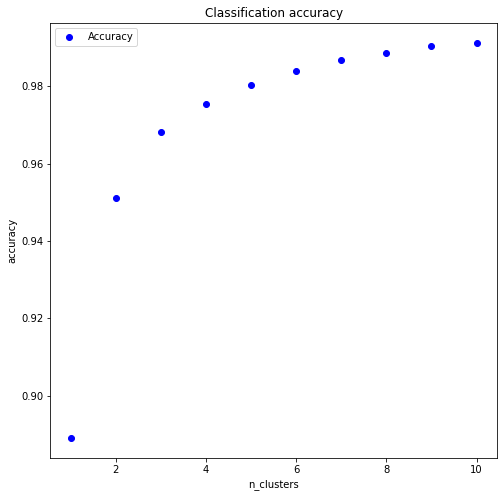

In [10]:
def extract_top_n_predictions_and_probs(y_pred, top_n):
    top_n_predictions = np.ndarray((y_pred.shape[0], top_n), dtype=np.uint32)
    top_n_probs = np.ndarray((y_pred.shape[0], top_n), dtype=np.float32)
    
    for i in range(0, y_pred.shape[0]):
        
        indices = y_pred[i, :].argsort()[-top_n:][::-1]
        top_n_predictions[i, :] = indices       
        top_n_probs[i, :]  = y_pred[i, indices]

    return top_n_predictions, top_n_probs

def accuracy(map_id_to_actual_class, map_id_to_predicted_class):
    
    image_ids = [image_id for image_id in map_id_to_predicted_class.keys()]
    accuracy = list()
    for i, image_id in enumerate(image_ids):
        actual_class = map_id_to_actual_class[image_id]
        predicted_class = map_id_to_predicted_class[image_id]
        
        if type(predicted_class) is not set:
            predicted_class = {predicted_class}
    
        if actual_class in predicted_class:
            accuracy.append(1.0)
        else:
            accuracy.append(0.0)
    
    return np.mean(accuracy)

range_values = range(1, 11)
accuracies = list()
for n in range_values:
    
    predicted_class, _ = extract_top_n_predictions_and_probs(y_pred, n)
    map_id_to_predicted_class = dict()
    for i, image_id in enumerate(ids['test']):
        map_id_to_predicted_class[image_id] = set(predicted_class[i, :])
    
    acc = accuracy(map_id_to_actual_class, map_id_to_predicted_class)
    accuracies.append(acc)
    
    print(f'Top {n} predictions. Accuracy {acc}')
    
# plot numbers
plt.figure(figsize=(8, 8))
plt.plot(range_values, accuracies, 'bo', label='Accuracy')
plt.title('Classification accuracy')
plt.xlabel('n_clusters')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Learnings:
- If we take the first 10 predictions we are not missing the actual class in over 99% of cases.
- This is the reason why we set `N_CLUSTER_CANDIDATES = 10` in the notebook parameters section above.

### Auxiliary mappings

In [11]:
predicted_clusters, predicted_probs = extract_top_n_predictions_and_probs(y_pred, N_CLUSTER_CANDIDATES)

map_id_to_predicted_clusters = dict()
map_id_to_predicted_probs = dict()
for i, image_id in enumerate(ids['test']):
    map_id_to_predicted_clusters[image_id] = predicted_clusters[i, :]
    map_id_to_predicted_probs[image_id] = predicted_probs[i, :]

In [12]:
map_id_to_distance_center = dict()
for _, row in target.iterrows():
    map_id_to_distance_center[row['id']] = row['distance']

map_class_to_image_ids = dict()
for image_id in ids['train']:
    c = map_id_to_actual_class[image_id]
    if c in map_class_to_image_ids:
        map_class_to_image_ids[c].append(image_id)
    else:
        map_class_to_image_ids[c] = [image_id]

### Extract for each image in train set information about its resolution and distance to the cluster center. We want to ensure the maps are covering enough area and represent all relevant resolutions.

In [ ]:
map_id_to_metadata = dict()
N_EXAMPLES_TO_USE = 10000 # we use a third of the train set
for image_id in tqdm(ids['train'][:N_EXAMPLES_TO_USE]):

    map_image = MapImage(image_id=image_id,
                         image_path=map_id_to_path[image_id],
                         coordinates=map_id_to_actual_coordinates[image_id])
    
    map_id_to_metadata[image_id] = {
        'cluster': map_id_to_actual_class[image_id],
        'px_per_lon_ratio': int(map_image.px_per_lon_ratio),
        'px_per_lat_ratio': int(map_image.px_per_lat_ratio),
        'll_lon': round(map_image.ll_lon, 2),
        'll_lat': round(map_image.ll_lat, 2),
        'ur_lon': round(map_image.ur_lon, 2),
        'ur_lat': round(map_image.ur_lat, 2),
        'distance_to_center': round(map_id_to_distance_center[image_id], 2)
    }
    
    del map_image

In [13]:
# TODO: remove it
with open(f'map_id_to_metadata_{N_CLASSES}clusters.json') as f:
    map_id_to_metadata = json.loads(f.read())

map_id_to_metadata

{'da81188565': {'cluster': 1,
  'px_per_lon_ratio': 156,
  'px_per_lat_ratio': 325,
  'll_lon': -73.68,
  'll_lat': 58.7,
  'ur_lon': -64.81,
  'ur_lat': 63.3,
  'distance_to_center': 2.04},
 'b950e501ac': {'cluster': 39,
  'px_per_lon_ratio': 308,
  'px_per_lat_ratio': 327,
  'll_lon': 91.35,
  'll_lat': 17.37,
  'ur_lon': 96.21,
  'ur_lat': 21.88,
  'distance_to_center': 5.3},
 '41b0df76ce': {'cluster': 140,
  'px_per_lon_ratio': 114,
  'px_per_lat_ratio': 240,
  'll_lon': -48.89,
  'll_lat': 57.86,
  'ur_lon': -37.0,
  'ur_lat': 64.11,
  'distance_to_center': 1.56},
 'd04786bfc4': {'cluster': 14,
  'px_per_lon_ratio': 328,
  'px_per_lat_ratio': 330,
  'll_lon': -56.09,
  'll_lat': 3.45,
  'ur_lon': -51.82,
  'ur_lat': 7.99,
  'distance_to_center': 9.9},
 '5747b05659': {'cluster': 8,
  'px_per_lon_ratio': 336,
  'px_per_lat_ratio': 377,
  'll_lon': 54.5,
  'll_lat': 25.97,
  'ur_lon': 58.96,
  'ur_lat': 28.28,
  'distance_to_center': 5.69},
 'ed8bf88f90': {'cluster': 48,
  'px_per_lo

### Generate set of representative maps per cluster

In [14]:
crm = ClusterRepresentativeMaps(
    N_MAP_CLUSTERS,
    N_MAPS_PER_CLUSTER,
    map_id_to_metadata,
    map_class_to_image_ids,
    map_id_to_path,
    map_id_to_actual_coordinates,
    resize_factor=RESIZE_FACTOR_TEMPLATE_MATCHING
)

crm.generate_map_class_to_map_ids()

# save to disk, as we are going to need it at prediction time
with open("cluster_representative_maps.pkl","wb") as f:
    pickle.dump(crm, f)

# with open("cluster_representative_maps.pkl","rb") as f:
#     crm_2 = pickle.load(f)
crm.generate_map_class_to_map_images()

Cluster 0, 16 maps
Cluster 1, 16 maps
Cluster 2, 16 maps
Cluster 3, 16 maps
Cluster 4, 16 maps
Cluster 5, 16 maps
Cluster 6, 16 maps
Cluster 7, 16 maps
Cluster 8, 16 maps
Cluster 9, 16 maps
Cluster 10, 16 maps
Cluster 11, 16 maps
Cluster 12, 16 maps
Cluster 13, 16 maps
Cluster 14, 16 maps
Cluster 15, 16 maps
Cluster 16, 16 maps
Cluster 17, 16 maps
Cluster 18, 16 maps
Cluster 19, 16 maps
Cluster 20, 16 maps
Cluster 21, 16 maps
Cluster 22, 16 maps
Cluster 23, 16 maps
Cluster 24, 16 maps
Cluster 25, 16 maps
Cluster 26, 16 maps
Cluster 27, 16 maps
Cluster 28, 16 maps
Cluster 29, 16 maps
Cluster 30, 16 maps
Cluster 31, 16 maps
Cluster 32, 16 maps
Cluster 33, 16 maps
Cluster 34, 16 maps
Cluster 35, 16 maps
Cluster 36, 16 maps
Cluster 37, 16 maps
Cluster 38, 16 maps
Cluster 39, 16 maps
Cluster 40, 16 maps
Cluster 41, 16 maps
Cluster 42, 16 maps
Cluster 43, 16 maps
Cluster 44, 16 maps
Cluster 45, 16 maps
Cluster 46, 16 maps
Cluster 47, 16 maps
Cluster 48, 16 maps
Cluster 49, 16 maps
Cluster 50

### Auxiliary functions

In [15]:
def get_deterministic_crop(image, crop_width, crop_height, crop_i, n_crops):
    """
    Deterministic way to get a crop.
    """
    width = image.shape[1]
    height = image.shape[0]

    if (crop_width > width) or (crop_height > height):
        raise Exception("Crop image does not fit in original image")

    # noise_x = random.uniform(0, 1)
    noise_x = crop_i/(n_crops + 1)
    x0 = int(noise_x * (height - crop_height))
    x1 = x0 + crop_height

    # noise_y = random.uniform(0, 1)
    noise_y = crop_i/(n_crops + 1)
    y0 = int(noise_y * (width - crop_width))
    y1 = y0 + crop_width

    top_left = [x0, y0]
    bottom_right = [x1, y1]

    return image[x0:x1, y0:y1, :], top_left, bottom_right

def normalize_lon(lon):
    
    if lon > 180:
        lon -= 360
    elif lon < -180:
        lon += 360
    
    return lon

def get_overlap_score_and_coordinates(template_image, framework_map_image):
    """
    Use template matching to find image 'template_image'
    inside the map 'framework_map_image'
    
    It returns both a normalized score and the coordinates
    of the crop.
    """
    # methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
    #            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

    # print('Templat image: ', type(template_image))
    # print('Framework image: ', type(framework_image))
    framework_image = framework_map_image.image

    method = cv2.TM_CCOEFF_NORMED
    result = cv2.matchTemplate(framework_image, template_image, method)
    (min_val, max_val, min_loc, max_loc) = cv2.minMaxLoc(result)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        score = -min_val
        top_left = min_loc
    else:
        score = max_val
        top_left = max_loc

    width = template_image.shape[1]
    height = template_image.shape[0]
    bottom_right = (top_left[0] + width, top_left[1] + height)

    # translate pixels into coordinates
    ll_lon = framework_map_image.ll_lon + (
            top_left[0] / framework_map_image.px_per_lon_ratio)
    ll_lon = normalize_lon(ll_lon)
    
    ur_lon = ll_lon + (width / framework_map_image.px_per_lon_ratio)
    ur_lon = normalize_lon(ur_lon)
    
    ur_lat = framework_map_image.ur_lat - (
            top_left[1] / framework_map_image.px_per_lat_ratio)
    ll_lat = ur_lat - (height / framework_map_image.px_per_lat_ratio)
        
    coordinates = [ll_lon, ll_lat, ur_lon, ur_lat]
    
    return score, coordinates

def get_map_coordinates_from_crop(map_image,
                                   crop_top_left, crop_bottom_right,
                                   px_per_lon_ratio, px_per_lat_ratio,
                                   crop_coordinates):
    """
    
    """
    x0 = crop_top_left[0]
    y0 = crop_top_left[1]
    x1 = crop_bottom_right[0]
    y1 = crop_bottom_right[1]

    ll_lon_crop = crop_coordinates[0]
    ll_lat_crop = crop_coordinates[1]
    ur_lon_crop = crop_coordinates[2]
    ur_lat_crop = crop_coordinates[3]

    ll_lon = ll_lon_crop - (y0 / px_per_lon_ratio)
    ll_lon = normalize_lon(ll_lon)
    ur_lon = ll_lon + (map_image.width_px / px_per_lon_ratio)
    ur_lon = normalize_lon(ur_lon)
    ur_lat = ur_lat_crop + (x0 / px_per_lat_ratio)
    ll_lat = ur_lat - (map_image.height_px / px_per_lat_ratio)
        
    map_coordinates = [ll_lon, ll_lat, ur_lon, ur_lat]

    return map_coordinates

def logger(message, debug=True, pid=None):
    """ Auxiliary function used for debugging """
    if debug:
        if pid:
            print(f'[{pid}] {message}')
        else:
            print(f'{message}')

def split_images_into_batches(images, n_batches):
    """ Auxiliary function to create batches of images """
    batch_size = math.ceil(len(images) / n_batches)
    images_batches = [images[i: i + batch_size]
                      for i in range(0, len(images), batch_size)]   
    
    return images_batches

In [148]:
def get_coordinates_one_image(map_image, pid):
    """
    Output:
    {
        'image_id': '12345',
        'score_0': 0.82,
        'score_1': 0.91,
        ...
        'score_9': 0.76,
        'predicted_coordinates_0': [x0, y0, z0, w0],
        ...
        'predicted_coordinates_9': [x9, y9, z9, w9],
    }
    """
    image_id = map_image.image_id
    
    print('Actual cluster: ', map_id_to_actual_class[image_id])
    print('Candidate clusters: ', map_id_to_predicted_clusters[image_id])
    print('Probs clusters: ', map_id_to_predicted_probs[image_id])
    
    cluster_candidates = map_id_to_predicted_clusters[image_id]
    cluster_probs = map_id_to_predicted_probs[image_id]
    if cluster_probs[0] > 0.95:
        # CNN is very sure about its prediction
        cluster_candidates = cluster_candidates[0:1]
        print('Candidate clusters: ', cluster_candidates)
    
    elif cluster_probs[0] > 0.70:
        # CNN is very sure about its prediction
        cluster_candidates = cluster_candidates[0:2]
        print('Candidate clusters: ', cluster_candidates)
    
    elif (cluster_probs[0] + cluster_probs[1]) > 0.70:
        # CNN is very sure about its prediction
        cluster_candidates = cluster_candidates[0:2]
        print('Candidate clusters: ', cluster_candidates)
        
    results = list()
    for crop_i in range(0, N_CROPS):

        # generate crop       
        crop_width_px = min([crm.get_min_width_px(c) for c in cluster_candidates])
        crop_height_px = min([crm.get_min_height_px(c) for c in cluster_candidates])
        crop_width_px = min(crop_width_px, map_image.width_px)
        crop_height_px = min(crop_height_px, map_image.height_px)       
        image_crop, crop_top_left, crop_bottom_right = \
            get_deterministic_crop(map_image.image, crop_width_px, crop_height_px,
                                  crop_i, N_CROPS)
        
        for cluster_i, cluster in enumerate(cluster_candidates):
            
            for j, map_image_representative in enumerate(crm.get_map_representatives(cluster)):

                # for this crop and map_representative, use template
                # matching to get a normalized score
                score, crop_coordinates = \
                    get_overlap_score_and_coordinates(
                        image_crop,
                        map_image_representative
                    )
                
                # given the crop, and the map where the the crop is located
                # infer the original image coordinates
                map_coordinates = get_map_coordinates_from_crop(
                    map_image,
                    crop_top_left,
                    crop_bottom_right,
                    map_image_representative.px_per_lon_ratio,
                    map_image_representative.px_per_lat_ratio,
                    crop_coordinates
                )               
                                                  
                results.append({
                    'cluster': cluster,
                    'score': score,
                    'coordinates': map_coordinates,
                })
                           
    # for each cluster find max score achieved
    #results = pd.DataFrame(results)
    x = pd.DataFrame(results).groupby(["cluster"])['score'].max().reset_index()
    #print(x)
           
    if len(cluster_candidates) == 2:
        cluster_0 = cluster_candidates[0]
        cluster_1 = cluster_candidates[1]
        #print('aux: ', x.loc[x.cluster == cluster_0, 'score'])        
        score_cluster_0 = x.loc[x.cluster == cluster_0, 'score'].tolist()[0]
        score_cluster_1 = x.loc[x.cluster == cluster_1, 'score'].tolist()[0]
        if score_cluster_1 > 0.95:
            # cluster 1 wins
            results = [r for r in results if r['cluster'] == cluster_1]
        elif score_cluster_0 > 0.85:
            # cluster 0 still wins
            results = [r for r in results if r['cluster'] == cluster_0]
                
    results.sort(key=lambda x: x['score'], reverse=True)    
    score = np.array(results[0]['score']).tolist()
    cluster = np.array(results[0]['cluster']).tolist()
    
    coordinates_0 = np.array(results[0]['coordinates'])
    coordinates_1 = np.array(results[1]['coordinates'])
    coordinates = (coordinates_0 + coordinates_1)/2
    
    predicted_coordinates = {
        'image_id': image_id,
        'coordinates': coordinates_0,
        'score': score,
        'cluster': cluster,
        'actual_cluster': map_id_to_actual_class[image_id]
    }
    #print(predicted_coordinates)
    
    return predicted_coordinates

def get_coordinates_one_batch(images):
    """ Worker method """
    
    pid = os.getpid()
    print(f'Started process {pid}. {len(images)} images to process')

    predicted_coordinates = list()   
    for i, image in enumerate(images):
        predicted_coordinates.append(get_coordinates_one_image(image, pid))
               
    print('Finished process ', pid)
    return predicted_coordinates

def get_coordinates(images):
    """
    """   
    n_processes = cpu_count()
#     n_processes = 1
       
    # split images into batches
    batches = split_images_into_batches(images, n_processes)
    n_batches = len(batches)
    print(f'{n_batches} batches')
    print(f'{n_processes} processes')
    
    if n_processes > 1:
        print(f'Starting pool with {n_processes} concurrent processes')
        with Pool(n_processes) as pool:
            output = pool.map(get_coordinates_one_batch,
                              batches)
        
            # output is a list of lists, compact output into single list
            coordinates = list()
            for x in output:
                for y in x:
                    coordinates.append(y)

    else:
        # for DEBUGGING purposes
        print('One process')
        coordinates = get_coordinates_one_batch(images)

    return coordinates

### Compute coordinate predictions for a subset of the test data

In [149]:
# tested_ids = [
#     '7282103538' # nothing to fix this
#     'f233a57908' # solved by adding 2 threshold levels.
# ]

# keep only images for which the nn is not so sure.
n_examples_to_use = 1000
test_ids = ids['test'][:n_examples_to_use]
batch_size = 100

# n_examples_to_use = 1
# test_ids = [
# #     '94d2e01e40',
# #     '888305fd5f'
# ]
# batch_size = 1

n_batches = n_examples_to_use // batch_size
output = list()
for batch in range(0, n_batches):
    print(f'Batch {batch+1} of {n_batches}')
    image_ids = test_ids[batch*batch_size:(batch+1)*batch_size]
    map_images = list()
    for image_id in image_ids:
        map_image = MapImage(image_id=image_id,
                             image_path=map_id_to_path[image_id])
        map_image.preprocess_image_new()
        
        # trick to speed up template matching
        # decrease resolution of the image
        map_image.resize_by_scaling_factor(RESIZE_FACTOR_TEMPLATE_MATCHING)
        
        map_images.append(map_image)

    output += get_coordinates(map_images)
    
    # save results to csv
    pd.DataFrame(output).to_csv('coordinates_lower_res.csv', index=False)

output

Batch 1 of 1
8 batches
8 processes
Starting pool with 8 concurrent processes
Started process 70700. 13 images to process
Actual cluster:  14
Candidate clusters:  [ 14  31   4  21 116 128  54  66  55  40]
Probs clusters:  [9.9728692e-01 7.2926050e-04 5.3675642e-04 3.8786069e-04 3.1112757e-04
 2.3841400e-04 9.1808237e-05 6.8281552e-05 6.2605213e-05 5.8263835e-05]
Candidate clusters:  [14]
Started process 70701. 13 images to process
Actual cluster:  134
Candidate clusters:  [117 134   2  77  29  21 136 127 120  54]
Probs clusters:  [8.8669658e-01 4.5438167e-02 3.6660064e-02 1.2817536e-02 1.0431525e-02
 4.1622845e-03 1.2153252e-03 5.4201065e-04 4.6873666e-04 2.9318346e-04]
Candidate clusters:  [117 134]
Started process 70702. 13 images to process
Actual cluster:  70
Candidate clusters:  [ 70 107  16  72  41  51 102 147 101 146]
Probs clusters:  [6.7559928e-01 3.1521824e-01 8.6445818e-03 1.8041958e-04 9.6341311e-05
 9.1804497e-05 3.9773247e-05 3.2779699e-05 2.5496325e-05 2.1658701e-05]
Cand

 1.02169986e-04 7.90472041e-05]
Candidate clusters:  [5]
   cluster     score
0       57  0.951811
Actual cluster:  30
Candidate clusters:  [ 30  48  58 111  63  79 142  29 100  71]
Probs clusters:  [0.6352631  0.24771956 0.03758756 0.02490911 0.0154458  0.01092413
 0.00819146 0.00667171 0.00476733 0.00206342]
Candidate clusters:  [30 48]
   cluster     score
0       83  0.878325
Actual cluster:  59
Candidate clusters:  [120  59  67 127   2  66 116 147 103 101]
Probs clusters:  [9.82015848e-01 1.73089374e-02 5.26927819e-04 1.02726095e-04
 2.58426680e-05 5.58092233e-06 5.54363123e-06 2.90249386e-06
 2.50769108e-06 4.67485449e-07]
   cluster     score
0       59  0.865191
Actual cluster:  76
Candidate clusters:  [120]
Candidate clusters:  [ 76  17  92  80  84  48  58 100  22  11]
Probs clusters:  [9.3572801e-01 2.1698939e-02 2.1516562e-02 1.5258807e-02 3.0325626e-03
 7.7315036e-04 2.7792898e-04 2.3368749e-04 2.2600594e-04 2.0257881e-04]
   cluster     score
0        5  0.792714
   cluste

1      122  0.903080
Actual cluster:  88
Candidate clusters:  [ 88   6  11  71 143  60 141  38  45 106]
Probs clusters:  [9.9706084e-01 2.0392344e-03 6.3323812e-04 9.3013776e-05 5.4794091e-05
 2.1423935e-05 1.9400040e-05 1.5120457e-05 1.2070034e-05 9.4461720e-06]
Candidate clusters:  [88]
   cluster     score
0       93  0.768636
Actual cluster:  6
Candidate clusters:  [  6 126   8  11 148   5 124  60  88 140]
Probs clusters:  [9.8025674e-01 1.3030356e-02 1.5887633e-03 1.3689245e-03 5.0895388e-04
 4.3720275e-04 3.2513114e-04 3.1648320e-04 2.8407521e-04 1.9840630e-04]
Candidate clusters:  [6]
   cluster     score
0       52  0.764094
Actual cluster:  5
Candidate clusters:  [  5  47   4  21  88  46 125 137  35 121]
Probs clusters:  [9.9967039e-01 8.9124325e-05 8.2256513e-05 3.3834072e-05 3.2813907e-05
 2.9504747e-05 2.4980129e-05 8.9524819e-06 8.2885335e-06 2.8810896e-06]
Candidate clusters:  [5]
   cluster     score
0      124  0.905932
Actual cluster:  128
Candidate clusters:  [128 102

 2.1898659e-04 1.5866187e-04 9.3750692e-05 1.9505447e-05 1.8894691e-05]
Candidate clusters:  [67]
   cluster     score
0       62  0.942863
Actual cluster:  50
Candidate clusters:  [ 50  22  70  18   9  96  69  57 109  36]
Probs clusters:  [9.9699163e-01 2.1276404e-03 5.6825177e-04 1.4293547e-04 3.7444097e-05
 2.7235315e-05 2.7100017e-05 1.1588328e-05 1.1467518e-05 1.0412129e-05]
Candidate clusters:  [50]
   cluster   score
0       52  0.8118
Actual cluster:  4
Candidate clusters:  [  4 128 119  27 103  59 116  17  13 127]
Probs clusters:  [9.9997222e-01 1.0019371e-05 7.7150025e-06 3.1430413e-06 2.5280733e-06
 1.3901122e-06 1.0608417e-06 5.6937580e-07 2.9247971e-07 2.3517144e-07]
Candidate clusters:  [4]
   cluster     score
0       67  0.807657
Finished process  70703
   cluster     score
0       91  0.982196
1      122  0.913529
Actual cluster:  86
Candidate clusters:  [ 86  58 117  69   2  42  45  77   5  16]
Probs clusters:  [9.9996221e-01 1.7331819e-05 1.0871232e-05 2.5522559e-06 

[{'image_id': '344863c1c2',
  'coordinates': array([-65.94412637,   7.48365436, -60.14556038,  13.21713261]),
  'score': 0.8192796111106873,
  'cluster': 14,
  'actual_cluster': 14},
 {'image_id': 'eb79ee0d58',
  'coordinates': array([-13.66335443,  49.2554027 ,  -5.3531248 ,  53.85166249]),
  'score': 0.9233338236808777,
  'cluster': 16,
  'actual_cluster': 16},
 {'image_id': '3607585889',
  'coordinates': array([-78.95500461,  17.20722817, -71.90444806,  24.17383585]),
  'score': 0.8651909232139587,
  'cluster': 59,
  'actual_cluster': 59},
 {'image_id': '3e5fcc7787',
  'coordinates': array([149.39527013, -35.07842489, 154.93015433, -30.20757324]),
  'score': 0.9844412207603455,
  'cluster': 76,
  'actual_cluster': 76},
 {'image_id': '1403381651',
  'coordinates': array([125.12599124, -34.24407854, 129.44431521, -30.28656982]),
  'score': 0.9030799269676208,
  'cluster': 122,
  'actual_cluster': 36},
 {'image_id': 'dbee7f7f72',
  'coordinates': array([153.29924494,  58.72147895, 168.

### Check RMSE

In [150]:
for i, p in enumerate(output):
    image_id = p['image_id']
    predicted = np.array(p['coordinates'])
    actual = map_id_to_actual_coordinates[image_id]   
    rmse = np.sqrt(((actual - predicted) ** 2).sum())   
    output[i]['rmse'] = rmse

# dataframe with results
results = list()
for p in output:
    results.append({
        'image_id': p['image_id'],
        'score': p['score'],
        'rmse': p['rmse'],
        'll_lon': round(p['coordinates'][0], 2),
        'll_lat': round(p['coordinates'][1], 2),
        'ur_lon': round(p['coordinates'][2], 2),
        'ur_lat': round(p['coordinates'][3], 2),
    })

results = pd.DataFrame(results)
print(results['rmse'].mean())

results.sort_values(by=['rmse'], inplace=True, ascending=False)
results.head(20)

7.758596100378998


,image_id,score,rmse,ll_lon,ll_lat,ur_lon,ur_lat
60,7282103538,0.874088,326.586223,147.01,-11.50,150.97,-9.06
13,f233a57908,0.900394,132.250968,-68.25,9.12,-64.13,12.14
55,7e50194583,0.962573,93.267778,-50.92,-27.96,-45.65,-23.05
17,c526ca553f,0.968335,88.575795,-12.20,2.84,-6.62,7.60
41,59f1250385,0.587916,8.000230,-15.32,49.69,-4.19,56.22
29,39491c3f9a,0.726890,7.983705,134.49,-5.40,140.56,1.67
4,1403381651,0.903080,7.372762,125.13,-34.24,129.44,-30.29
48,43ac8b4680,0.768925,7.052385,131.81,-35.30,136.98,-31.21
62,fbafd50d15,0.432741,6.011556,117.04,-10.81,120.48,-5.86
68,4247017eb7,0.674274,4.261380,133.40,33.64,137.07,37.82
